# Barcelona

## Gradient Boosting Trees

### Gradient Boosting Regressor

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import MinMaxScaler 
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, mean_squared_error

import multiprocessing

import warnings
warnings.filterwarnings('once')

In [2]:
df_total = pd.read_excel('Total.xls')
# Edit columns names + Lower case column names
df_total.columns = map(str.lower, df_total.columns)
df_total.columns

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['sub_region_2', 'fecha', 'provincia_iso', 'num_casos.x',
       'num_casos_prueba_pcr', 'num_casos_prueba_test_ac',
       'num_casos_prueba_ag', 'num_casos_prueba_elisa',
       'num_casos_prueba_desconocida', 'num_casos.y', 'num_hosp', 'num_uci',
       'num_def', 'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline', 'total'],
      dtype='object')

In [3]:
Bar = df_total.loc[df_total['sub_region_2'] == 'Barcelona']
#Bar.describe()

In [5]:
# We select columns of interest (mobility ones)
#Bar = Bar[['num_casos.x']+['num_casos_prueba_pcr']+ list(Bar.loc[:,'retail_and_recreation_percent_change_from_baseline':'total'])]
Bar = Bar[['num_casos.x']+ list(Bar.loc[:,'retail_and_recreation_percent_change_from_baseline':'total'])]
#Bar_red

In [4]:
# Set index 
Bar = Bar.set_index('fecha')

In [6]:
# We create train and test datasets as in previous scenarios
X_train, X_test, y_train, y_test = train_test_split( #Bar,
                                                    Bar.drop(columns = 'num_casos.x'),                                                    
                                                    Bar['num_casos.x'],
                                                    shuffle = False, stratify = None, 
                                                    train_size=0.942)

In [7]:
# Model generation
model = GradientBoostingRegressor(n_estimators = 10,
                                  loss         = 'ls',
                                  max_features = 'auto',
                                  random_state = 123)

model.fit(X_train, y_train)

# Prediction
predictions = model.predict(X = X_test)
rmse = mean_squared_error(y_test, predictions, squared = False)
print(f" RMSE: {rmse}")

 RMSE: 751.5731851370354


In [8]:
type(y_test)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


pandas.core.series.Series

In [9]:
type(X_test)

pandas.core.frame.DataFrame

In [10]:
#X_test

Optimal n_estimators: 101


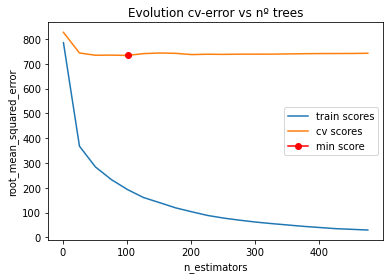

In [11]:
# Validation with k-cross-validation and neg_root_mean_squared_error
train_scores = []
cv_scores    = []

# Values used
estimator_range = range(1, 500, 25)

# Train esach model with each values for n_estimators and extract its error
# test and k-cross-validation.
for n_estimators in estimator_range:    
    model = GradientBoostingRegressor(
                n_estimators = n_estimators,
                loss         = 'ls',
                max_features = 'auto',
                random_state = 123)
    
    # Error train
    model.fit(X_train, y_train)
    predictions = model.predict(X = X_train)
    rmse = mean_squared_error(
            y_true  = y_train,
            y_pred  = predictions,
            squared = False
           )
    train_scores.append(rmse)    
    # Error cv
    scores = cross_val_score(
                estimator = model,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5,
                n_jobs    = multiprocessing.cpu_count() - 1,
             )
    # aggregate scores cross_val_score() and pass to possitive
    cv_scores.append(-1*scores.mean())
    
# plot error evolution
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, cv_scores, label="cv scores")
ax.plot(estimator_range[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("n_estimators")
ax.set_title("Evolution cv-error vs nº trees")
plt.legend();
print(f"Optimal n_estimators: {estimator_range[np.argmin(cv_scores)]}")

In [12]:
# Validation k-cross-validation and neg_root_mean_squared_error
results = {}

# Values used
learning_rates = [0.001, 0.01, 0.1]
n_estimators   = [10, 20, 100, 200, 300, 400, 500, 1000, 2000, 5000]

# model train for each combination of learning_rate + n_estimator 
# we get the error for tain and k-cross-validation.
for learning_rate in learning_rates:
    train_scores = []
    cv_scores    = []
    
    for n_estimator in n_estimators:
    
        model = GradientBoostingRegressor(
                    n_estimators  = n_estimator,
                    learning_rate = learning_rate,
                    loss          = 'ls',
                    max_features  = 'auto',
                    random_state  = 123
                 )

        # Error train
        model.fit(X_train, y_train)
        predictions = model.predict(X = X_train)
        rmse = mean_squared_error(
                y_true  = y_train,
                y_pred  = predictions,
                squared = False
               )
        train_scores.append(rmse)

        # Error CV
        scores = cross_val_score(
                    estimator = model,
                    X         = X_train,
                    y         = y_train,
                    scoring   = 'neg_root_mean_squared_error',
                    cv        = 3,
                    n_jobs    = multiprocessing.cpu_count() - 1
                 )
        # aggregate scores cross_val_score() and pass to possitive
        cv_scores.append(-1*scores.mean())     
        
    results[learning_rate] = {'train_scores': train_scores, 'cv_scores': cv_scores}

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


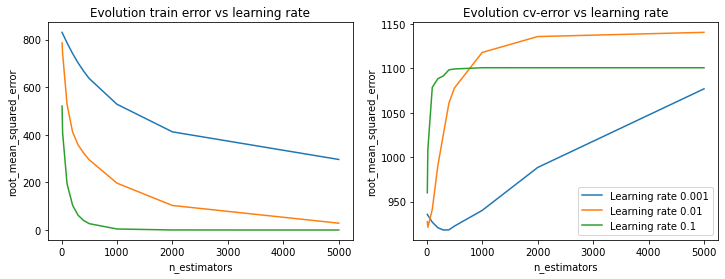

In [13]:
# plot error evolution
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

for key, value in results.items():
    axs[0].plot(n_estimators, value['train_scores'], label=f"Learning rate {key}")
    axs[0].set_ylabel("root_mean_squared_error")
    axs[0].set_xlabel("n_estimators")
    axs[0].set_title("Evolution train error vs learning rate")
    
    axs[1].plot(n_estimators, value['cv_scores'], label=f"Learning rate {key}")
    axs[1].set_ylabel("root_mean_squared_error")
    axs[1].set_xlabel("n_estimators")
    axs[1].set_title("Evolution cv-error vs learning rate")
    plt.legend();

Optimal max_depth: 3


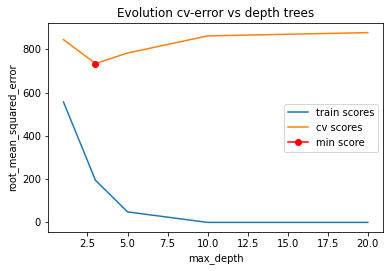

In [14]:
# Validation k-cross-validation and neg_root_mean_squared_error
train_scores = []
cv_scores    = []

# Values used
max_depths = [1, 3, 5, 10, 20]

# Train model for each max_depth
for max_depth in max_depths:
    
    model = GradientBoostingRegressor(
                n_estimators = 100,
                loss         = 'ls',
                max_depth    = max_depth,
                max_features = 'auto',
                random_state = 123
             )
    
    # Error train
    model.fit(X_train, y_train)
    predictions = model.predict(X = X_train)
    rmse = mean_squared_error(
            y_true  = y_train,
            y_pred  = predictions,
            squared = False
           )
    train_scores.append(rmse)
    
    # Error CV
    scores = cross_val_score(
                estimator = model,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5,
                n_jobs    = multiprocessing.cpu_count() - 1
             )
    # aggregate scores cross_val_score() pass to possitve
    cv_scores.append(-1*scores.mean())
    
# plots erros evolution
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(max_depths, train_scores, label="train scores")
ax.plot(max_depths, cv_scores, label="cv scores")
ax.plot(max_depths[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("max_depth")
ax.set_title("Evolution cv-error vs depth trees")
plt.legend();
print(f"Optimal max_depth: {max_depths[np.argmin(cv_scores)]}")

In [15]:
# Grid hyperparmeters
param_grid = {'max_features'  : ['auto', 'sqrt', 'log2'],
              'max_depth'     : [None, 1, 3, 5, 10, 20],
              'subsample'     : [0.5, 1],
              'learning_rate' : [0.001, 0.01, 0.1]
             }

# Grid-search with cv
grid = GridSearchCV(
        estimator  = GradientBoostingRegressor(
                        n_estimators        = 1000, 
                        random_state        = 123,
                        # Early stop #
                        validation_fraction = 0.1,
                        n_iter_no_change    = 5,
                        tol                 = 0.0001
                    ),
        param_grid = param_grid,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=3, n_repeats=1, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Results
results = pd.DataFrame(grid.cv_results_)
results.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,param_learning_rate,param_max_depth,param_max_features,param_subsample,mean_test_score,std_test_score,mean_train_score,std_train_score
101,0.1,10,log2,1,-504.012062,82.438033,-150.884075,68.412845
99,0.1,10,sqrt,1,-504.012062,82.438033,-150.884075,68.412845
100,0.1,10,log2,0.5,-509.470805,82.081744,-208.386767,49.100794
98,0.1,10,sqrt,0.5,-509.470805,82.081744,-208.386767,49.100794


In [16]:
# Best hyperparameters by cv
print("--------------------------")
print("Best hyperparameters by cv")
print("--------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

--------------------------
Best hyperparameters by cv
--------------------------
{'learning_rate': 0.1, 'max_depth': 10, 'max_features': 'sqrt', 'subsample': 1} : -504.01206211172894 neg_root_mean_squared_error


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
# Error test 
model = grid.best_estimator_
predictions = model.predict(X = X_test)
rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predictions,
        squared = False
       )
print(f"rmse test: {rmse}")

rmse test: 760.553658193893


In [18]:
importance_predictors = pd.DataFrame({#'predictor': Bar.columns,
                                    'predictor': Bar.drop(columns = 'num_casos.x').columns,
                                      'importance': model.feature_importances_})
print("Importance of predictors")
print("------------------------")
importance_predictors.sort_values('importance', ascending=False)

Importance of predictors
------------------------


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,predictor,importance
4,workplaces_percent_change_from_baseline,0.216988
1,grocery_and_pharmacy_percent_change_from_baseline,0.205783
0,retail_and_recreation_percent_change_from_base...,0.179101
2,parks_percent_change_from_baseline,0.165744
3,transit_stations_percent_change_from_baseline,0.092964
5,residential_percent_change_from_baseline,0.080427
6,total,0.058992


In [19]:
importance = permutation_importance(
                estimator    = model,
                X            = X_train,
                y            = y_train,
                n_repeats    = 5,
                scoring      = 'neg_root_mean_squared_error',
                n_jobs       = multiprocessing.cpu_count() - 1,
                random_state = 123
             )

# Store results (mean / sd) 
df_importance = pd.DataFrame(
                    {k: importance[k] for k in ['importances_mean', 'importances_std']}
                 )
df_importance['feature'] = X_train.columns
df_importance.sort_values('importances_mean', ascending=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,importances_mean,importances_std,feature
1,383.988977,9.819925,grocery_and_pharmacy_percent_change_from_baseline
2,362.031663,13.450823,parks_percent_change_from_baseline
4,314.458768,11.624081,workplaces_percent_change_from_baseline
0,232.872737,17.073203,retail_and_recreation_percent_change_from_base...
3,205.843826,14.133023,transit_stations_percent_change_from_baseline
5,184.347571,2.092489,residential_percent_change_from_baseline
6,138.491546,5.596702,total


In [20]:
# Calculate the mean absolute error (MAE)
mae = mean_absolute_error(predictions, y_test)
print('MAE: ' + str(round(mae, 5)))

# Calculate the root mean squarred error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test,predictions))
print('RMSE: ' + str(round(rmse, 5)))

MAE: 617.48826
RMSE: 760.55366


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
predictions_df = pd.DataFrame(predictions)
predictions_df.rename(columns={0:'Pred'},inplace=True)
y_test_df=pd.DataFrame(y_test)
y_test_df.reset_index(drop=True, inplace=True)
y_test_df
predictions_df['yt']=y_test_df['num_casos.x']
predictions_df

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Pred,yt
0,905.010118,1444
1,1019.998491,1477
2,1264.662641,1320
3,1179.102730,1353
4,899.329236,1477
5,884.459611,1078
6,1009.307176,994
7,1653.700030,1785
8,1177.128234,1763
9,1112.750619,1616


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


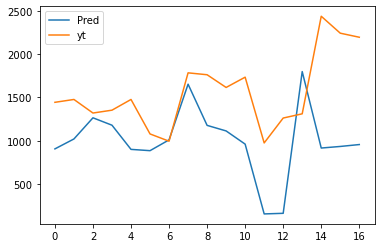

In [22]:
_ = predictions_df.plot()

## XGboost (Supervised)

Following code is extracted from Brownlee (2020) for check porposes.

Brownlee, J., 2021. How to Use XGBoost for Time Series Forecasting. [online] Machine Learning Mastery. Available at: <https://machinelearningmastery.com/xgboost-for-time-series-forecasting/> [Accessed 17 May 2021].

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:119: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


>expected=1444.0, predicted=954.1
>expected=1477.0, predicted=1116.8
>expected=1320.0, predicted=1386.6
>expected=1353.0, predicted=1484.4
>expected=1477.0, predicted=1305.3
>expected=1078.0, predicted=1252.3
>expected=994.0, predicted=1036.6
>expected=1785.0, predicted=1206.6
>expected=1763.0, predicted=1665.1
>expected=1616.0, predicted=1585.4
>expected=1735.0, predicted=1728.1
>expected=974.0, predicted=1717.4
>expected=1262.0, predicted=974.1
>expected=1311.0, predicted=1602.3
>expected=2440.0, predicted=1512.8
>expected=2244.0, predicted=2853.6
>expected=2197.0, predicted=2475.1
RMSE: 407.815


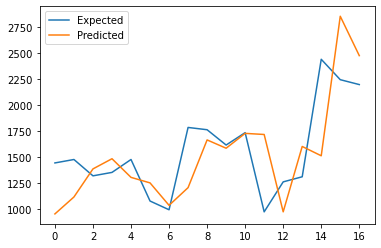

In [23]:
from numpy import asarray
from pandas import DataFrame
from pandas import concat
from xgboost import XGBRegressor
from matplotlib import pyplot
 
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[0]
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values
 
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]
 
# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
	# transform list into array
	train = asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict(asarray([testX]))
	return yhat[0]
 
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = xgboost_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_squared_error(test[:, -1], predictions, squared = False)
    #error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, -1], predictions
 
# load the dataset
values = Bar['num_casos.x'].values
# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=14)
# evaluate
mae, y, yhat = walk_forward_validation(data,17)
#print('MAE: %.3f' % mae)
print('RMSE: %.3f' % mae)
# plot expected vs preducted
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.show()